# 第8期機械学習コース　Day3通し課題

## Data:　Car fuel consumption

## Day２の改善点
- Day1での外れ値を全て説明変数に取り込む
- Specialを特徴量に追加
- 標準化を採用
- 線形には全ての正則化（Lasso,Ridge,ElasticNet）
- SVC（線形、非線形）
- 交差検証ごとのハイパーパラメーターの関係を可視化

## Day3の改善点⇒１説明変数の追加と２統計的視点
- 外れ値の処理に取り組む
    - 3σ⇒１００個体該当
    - 5σ⇒４４個体該当
    - 4分位
    - 説明変数にのみ外れ値を置換（平均、中央値、最頻値、前後の値）⇒結局、、どれも精度でないので却下
    
    
- 説明変数の追加
    - ヒーターOFF、外気温を車の中の温度NANで欠損値追加、外気温と車内温度の差
    - 2乗項、3乗項の追加
    
    
- データの型を統一


- アルゴリズムの追加
    - ランダムフォレスト
    - 単層ニューラルネット、深層ニューラルネット
    - XGBoost


- 更なるチューニング
    - ステップワイズ法による次元削減
    - ランダムフォレストからの重要な特徴量抽出⇒ランキングごとで説明変数の並び替え⇒20次元から4次元でMAEを測定
    - 単変量統計p-valueによる枝刈り
    - XGBoostと埋め込み法による次元削減

## データの可視化で分かったこと
- データのばらつきが分かった
- ハイパーパラメータのチューニングがしやすかった
- 特徴量選択に有効であった

## 結果
- MAE=0.428
- アルゴリズム：XGBoost
- チューニング前の値・・・

## 反省
- 統計的な視点や回帰独特の問題に取り組めた
- チューニングのときもランダムファレストで並び方をかえただけで、次元削減できそうなのは興味深かった
-  XGBoostさまさまでした


- コードがみなさんのものと比べて乱雑だなぁと感じました。
- 統計的な視点やチューニング頑張ったけど精度がでなかった。⇒P-valudeは散々な結果⇒AICを見るべきか
- アルゴリズムをブラックボックスで使っている。


そもそも単純に燃料の消費量は車種とかが重要な説明変数になるのではないか？Distance/cosumeとかで仮の車種の特徴量を作成して3クラスくらい分けてみてもいいかもと思いました。⇒実査にやってみると異常に良い数値が。。MAE0.3代だった。。。。でも、Consumeは目的変数だからあまりよくないのか。。。？？

## 必要ライブラリのインポート

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb  # Day3追加
from keras.layers import BatchNormalization, Dense, Dropout, Input  # Day3追加
from keras.models import Sequential  # Day3追加
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, RMSprop  # Day3追加
from keras.wrappers.scikit_learn import KerasRegressor  # Day3追加
from sklearn.ensemble import RandomForestRegressor  # Day3追加
from sklearn.feature_selection import SelectFromModel  # Day4追加
from sklearn.feature_selection import SelectPercentile  # P-value単変量統計
from sklearn.linear_model import ElasticNet, Lasso, Ridge
# from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score,classification_report
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold  # Day3追加
from sklearn.model_selection import cross_val_score  # Day3追加
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.pipeline import Pipeline  # Day3追加
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR

import japanize_matplotlib  # Matplotlibが日本語対応して簡単に実装！

from sklearn.linear_model import LassoCV  # 正則化項付き最小二乗法を行うためのライブラリ; Day4追加


%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>')) # 表示エリア拡大・大きくなるおまじない

## Dataの読み込み

In [3]:
df = pd.read_excel('measurements2.xlsx')

## 基礎集計

In [4]:
df.info()
#欠損値temp_inside、specials、refill、liters、refill gasに多い

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [5]:
df.shape

(388, 12)

In [6]:
for x in df.columns:
    print(x)

distance
consume
speed
temp_inside
temp_outside
specials
gas_type
AC
rain
sun
refill liters
refill gas


In [7]:
df.head(3)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [8]:
df.tail(3)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
385,16.0,3.8,45,25.0,19,NaN,SP98,0,0,0,NaN,NaN
386,15.4,4.6,42,25.0,31,AC,SP98,1,0,0,NaN,NaN
387,14.7,5.0,25,25.0,30,AC,SP98,1,0,0,NaN,NaN


In [9]:
df.isnull().sum()
#regill_litersとrefill_gasに欠損値多い

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

In [10]:
for feature in df.columns:
    print(feature+':\n'+str(df[feature].unique())+':\n' )
#SpecialはAC,rain,sun項目を表した文字情報（カテゴリカル変数）重複しているため消去してもいいかも。
#Day2では、「Special」もよい特徴量になる可能性があるため、これも加味していく。

distance:
[ 28.   12.   11.2  12.9  18.5   8.3   7.8  12.3   4.9  11.9  12.4  11.8
  24.7  17.3  33.4  25.9  25.3  14.2  17.9  18.4  18.3  32.6  19.   12.1
  20.    4.5  11.7  10.2   5.4   2.   16.   27.3  10.6  11.6  13.1   6.1
 153.5   2.9   2.1   9.8   6.8  14.   13.9   9.7  24.8  34.8   5.2  10.5
  13.2  13.   12.2  12.5  15.7   6.4   5.3  26.2  18.8  22.9 162.7  16.6
  15.9   5.1  22.4  31.1  16.1   4.2  17.4  23.5   7.   20.1  20.8   1.7
  35.9  36.9  16.8   9.9  36.6  44.9  21.6  39.4  26.6  53.2  18.9  43.5
  16.4  21.1  22.7  44.4  35.8  40.6  14.1  58.7  16.2  31.8  51.6  38.6
  81.2 130.3  67.2  43.7  56.1  39.   38.5  28.2  19.6  22.2  13.6  12.6
   8.7   7.9   2.4  18.1   1.3  13.4  12.8  29.   31.4  27.1  25.2  14.3
  16.9   9.2  31.5  24.9  17.    7.4  25.7  24.5   4.1  15.4 101.9  93.9
  32.1  48.6  37.2  28.8   6.7   6.6  13.3  12.7  16.5  20.6  16.3  18.7
  36.5  29.9  10.1  31.9  10.8  19.8  11.3  11.5  21.4  32.   41.9 211.
 216.1  25.5  22.1  39.5  21.5   4.8 100.9

In [11]:
df.describe()
#ConsumeとDistanceの最大値が平均よりおおきく離れている。⇒外れ値の可能性

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


## データの可視化

In [12]:
#各特徴量の相関係数の可視化:
df.corr().style.background_gradient().format("{:.2f}")

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
distance,1.00,-0.13,0.56,0.08,0.09,-0.03,-0.02,0.08,0.13
consume,-0.13,1.00,-0.23,-0.16,-0.32,0.10,0.25,-0.17,0.10
speed,0.56,-0.23,1.00,0.06,0.02,-0.04,0.01,0.08,0.05
temp_inside,0.08,-0.16,0.06,1.00,0.36,0.30,-0.04,0.25,0.03
temp_outside,0.09,-0.32,0.02,0.36,1.00,0.17,-0.19,0.35,-0.08
AC,-0.03,0.10,-0.04,0.30,0.17,1.00,0.24,0.09,nan
rain,-0.02,0.25,0.01,-0.04,-0.19,0.24,1.00,-0.11,-0.49
sun,0.08,-0.17,0.08,0.25,0.35,0.09,-0.11,1.00,nan
refill liters,0.13,0.10,0.05,0.03,-0.08,nan,-0.49,nan,1.00


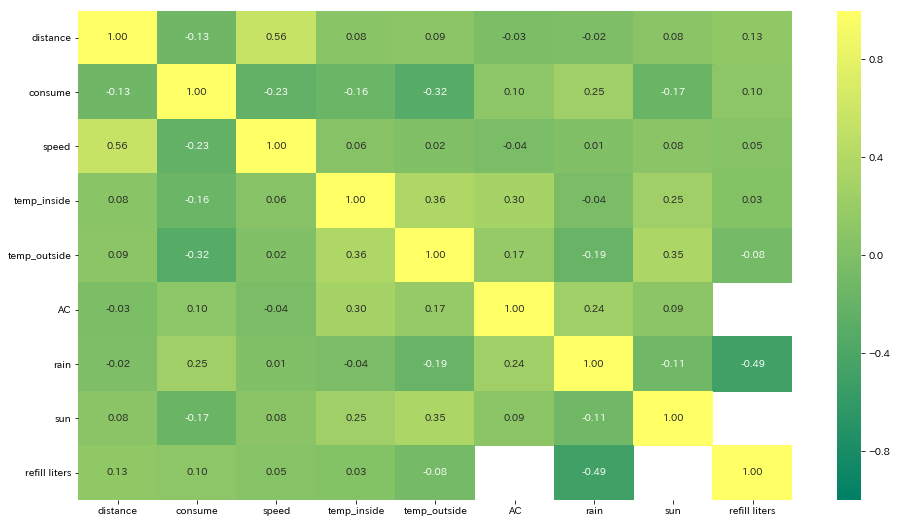

In [13]:
f,ax=plt.subplots(figsize=(16,9))
sns.heatmap(df.corr(),cmap="summer",annot=True,fmt='.2f',vmax=1.0,vmin=-1.0)

In [14]:
#sns.pairplot(df)

In [15]:
# #ラベルごとの散布図を表記。。
# import itertools
# li_combi = list(itertools.combinations(df.columns[1:], 2))
# for X,Y in li_combi:
#     print("X=%s"%X,"Y=%s"%Y)
#     df.plot(kind="scatter",x=X,y=Y,alpha=0.7,s=10,c="Class label",colormap="winter")#散布図の作成
#     plt.xlabel(X)
#     plt.ylabel(Y)
#     plt.tight_layout()
#     plt.show()#グラフをここで描画させるための行

In [16]:
# sns.set(style="ticks")


# for col in df.columns.values:

#     if col == "consume":
#         continue;
#     sns.catplot(x=col, y="consume", data=df, height=5, aspect=3)

AxesSubplot(0.125,0.125;0.775x0.755)


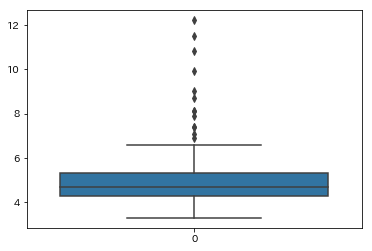

In [17]:
#外れ値が多そうなdistancetとConsumeを箱ひげ図で確認
print(sns.boxplot(data=df["consume"],whis=1.5))

AxesSubplot(0.125,0.125;0.775x0.755)


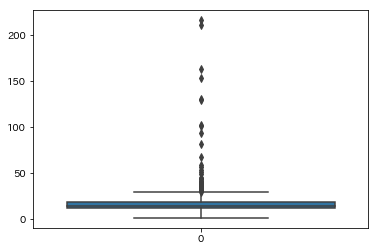

In [18]:
print(sns.boxplot(data=df["distance"],whis=1.5))

## 前処理

### 説明変数の作成

In [19]:
# ヒーター使用していない場合はOFFという説明変数０．１で作成
df['heating_off']=df['temp_inside'].isnull()
df['heating_off']=df['heating_off'].apply(float)
# Temp_insideがNanaだとヒーターを使用していないため、外気温と同じであると仮定
df['temp_inside'].fillna(df['temp_outside'], inplace=True)
# 気温差の説明変数を作成。２乗項も入れる⇒表現豊かになるらしい
df['temp_diff'] = df['temp_inside'] - df['temp_outside']
df['temp_diff_square'] = df['temp_diff']**2
# スピードの２乗項と３乗項を追加
df['speedsquare'] = df['speed']**2  
df['speedcube'] =  df['speed']**3 
#距離の２乗項追加
#df['distancesquare'] = df['distance']**2  
#リッターあたりの効率を車種として説明変数へ
#df["car_type"] = df["distance"] / df["consume"]

# ガスのタイプを読みやすく
def gastype(in_string):
    '''gas type in, integer out'''
    if in_string == "E10":
        return 0
    else:
        return 1
df['gas_type_num']= df['gas_type'].apply(gastype)
print(df.groupby(by='gas_type')['consume'].mean().round(2))

gas_type
E10     4.93
SP98    4.90
Name: consume, dtype: float64


In [20]:
df.shape

(388, 18)

In [21]:
df.head(5)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,heating_off,temp_diff,temp_diff_square,speedsquare,speedcube,gas_type_num
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10,0.0,9.5,90.25,676,17576,0
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN,0.0,8.5,72.25,900,27000,0
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.0,6.5,42.25,1444,54872,0
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN,0.0,7.5,56.25,1296,46656,0
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.0,6.5,42.25,2116,97336,0


In [22]:
for feature in df.columns:
    print(feature+':\n'+str(df[feature].unique())+':\n' )

distance:
[ 28.   12.   11.2  12.9  18.5   8.3   7.8  12.3   4.9  11.9  12.4  11.8
  24.7  17.3  33.4  25.9  25.3  14.2  17.9  18.4  18.3  32.6  19.   12.1
  20.    4.5  11.7  10.2   5.4   2.   16.   27.3  10.6  11.6  13.1   6.1
 153.5   2.9   2.1   9.8   6.8  14.   13.9   9.7  24.8  34.8   5.2  10.5
  13.2  13.   12.2  12.5  15.7   6.4   5.3  26.2  18.8  22.9 162.7  16.6
  15.9   5.1  22.4  31.1  16.1   4.2  17.4  23.5   7.   20.1  20.8   1.7
  35.9  36.9  16.8   9.9  36.6  44.9  21.6  39.4  26.6  53.2  18.9  43.5
  16.4  21.1  22.7  44.4  35.8  40.6  14.1  58.7  16.2  31.8  51.6  38.6
  81.2 130.3  67.2  43.7  56.1  39.   38.5  28.2  19.6  22.2  13.6  12.6
   8.7   7.9   2.4  18.1   1.3  13.4  12.8  29.   31.4  27.1  25.2  14.3
  16.9   9.2  31.5  24.9  17.    7.4  25.7  24.5   4.1  15.4 101.9  93.9
  32.1  48.6  37.2  28.8   6.7   6.6  13.3  12.7  16.5  20.6  16.3  18.7
  36.5  29.9  10.1  31.9  10.8  19.8  11.3  11.5  21.4  32.   41.9 211.
 216.1  25.5  22.1  39.5  21.5   4.8 100.9

### カテゴリカル変数のダミー変数の挿入

In [23]:
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [24]:
# df["gas_type"].values
df= pd.concat([df, pd.get_dummies(df["gas_type"])], axis=1)
#display(pd.get_dummies(df["gas_type"]))


In [25]:
df.head(3)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,heating_off,temp_diff,temp_diff_square,speedsquare,speedcube,gas_type_num,E10,SP98
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10,0.0,9.5,90.25,676,17576,0,1,0
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN,0.0,8.5,72.25,900,27000,0,1,0
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.0,6.5,42.25,1444,54872,0,1,0


In [26]:
df = df.drop("gas_type", axis = 1)

In [27]:
##前処理
df.columns

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'specials', 'AC', 'rain', 'sun', 'refill liters', 'refill gas',
       'heating_off', 'temp_diff', 'temp_diff_square', 'speedsquare',
       'speedcube', 'gas_type_num', 'E10', 'SP98'],
      dtype='object')

### 欠損値の処理

In [28]:
#"refill liters"と"refill gas"欠損値の比率が大きい
print("refill liters: {:.3f}".format(df["refill liters"].isnull().sum() / df.shape[0]))
print("refill gas: {:.3f}".format(df["refill gas"].isnull().sum() / df.shape[0]))

refill liters: 0.966
refill gas: 0.966


In [29]:
#このためいずれも特徴量から除去する
df = df.drop("refill liters", axis = 1)
df = df.drop("refill gas", axis = 1)

In [30]:
print("temp_inside: {:.3f}".format(df["temp_inside"].isnull().sum() / df.shape[0]))

temp_inside: 0.000


In [31]:
#Temp_insideに関しては欠損の比率は少ないため無難に平均値で埋める
df["temp_inside"].fillna(df["temp_inside"].mean(), inplace=True)

### 不要な特徴量の処理⇒Day2では新たな特徴量として考慮

In [32]:
#SpecialはAC,rain,sun項目を表した文字情報（カテゴリカル変数）。重複しているため消去してもいいかも
# df = df.drop("specials", axis = 1)
# for x in df.columns:
#     print(x)

# df.isnull().sum()

In [33]:
#specialsの中身をまずカウント
df['specials'].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
sun ac                 3
snow                   3
AC snow                1
AC sun                 1
ac rain                1
AC Sun                 1
half rain half sun     1
Name: specials, dtype: int64

In [34]:
#rain,sun,AC,snow,half rain half sunに統一
df.loc[df['specials'] == 'AC', 'specials'] = 'AC_special'
df.loc[df['specials'] == 'Sun', 'specials'] = 'sun_special'
df.loc[df['specials'] == 'sun', 'specials'] = 'sun_special'
df.loc[df['specials'] == 'ac', 'specials'] = 'AC_special'
df.loc[df['specials'] == 'AC Sun', 'specials'] = 'sun_special'
df.loc[df['specials'] == 'sun ac', 'specials'] = 'sun_special'
df.loc[df['specials'] == 'AC sun', 'specials'] = 'sun_special'
df.loc[df['specials'] == 'rain', 'specials'] = 'rain_special'
df.loc[df['specials'] == 'AC rain', 'specials'] = 'rain_special'
df.loc[df['specials'] == 'ac rain', 'specials'] = 'rain_special'
df.loc[df['specials'] == 'AC snow', 'specials'] = 'snow_special'
df.loc[df['specials'] == 'snow', 'specials'] = 'snow_special'
df['specials'].value_counts()

rain_special          42
sun_special           32
AC_special            14
snow_special           4
half rain half sun     1
Name: specials, dtype: int64

In [35]:
df= pd.concat([df, pd.get_dummies(df["specials"])], axis=1)
df.head(3)

,distance,consume,speed,temp_inside,temp_outside,specials,AC,rain,sun,heating_off,...,speedsquare,speedcube,gas_type_num,E10,SP98,AC_special,half rain half sun,rain_special,snow_special,sun_special
0,28.0,5.0,26,21.5,12,NaN,0,0,0,0.0,...,676,17576,0,1,0,0,0,0,0,0
1,12.0,4.2,30,21.5,13,NaN,0,0,0,0.0,...,900,27000,0,1,0,0,0,0,0,0
2,11.2,5.5,38,21.5,15,NaN,0,0,0,0.0,...,1444,54872,0,1,0,0,0,0,0,0


In [36]:
df = df.drop("specials", axis = 1)

In [37]:
df['speed'] = df['speed'].astype(float)
df['temp_outside'] = df['temp_outside'].astype(float)
df['AC'] = df['AC'].astype(float)
df['rain'] = df['rain'].astype(float)
df['sun'] = df['sun'].astype(float)
df['speedsquare'] = df['speedsquare'].astype(float)
df['speedcube'] = df['speedcube'].astype(float)
df['gas_type_num'] = df['gas_type_num'].astype(float)

In [38]:
print(df.shape)
print(df.isnull().sum())
display(df.dtypes)

(388, 21)
distance              0
consume               0
speed                 0
temp_inside           0
temp_outside          0
AC                    0
rain                  0
sun                   0
heating_off           0
temp_diff             0
temp_diff_square      0
speedsquare           0
speedcube             0
gas_type_num          0
E10                   0
SP98                  0
AC_special            0
half rain half sun    0
rain_special          0
snow_special          0
sun_special           0
dtype: int64


distance              float64
consume               float64
speed                 float64
temp_inside           float64
temp_outside          float64
AC                    float64
rain                  float64
sun                   float64
heating_off           float64
temp_diff             float64
temp_diff_square      float64
speedsquare           float64
speedcube             float64
gas_type_num          float64
E10                     uint8
SP98                    uint8
AC_special              uint8
half rain half sun      uint8
rain_special            uint8
snow_special            uint8
sun_special             uint8
dtype: object

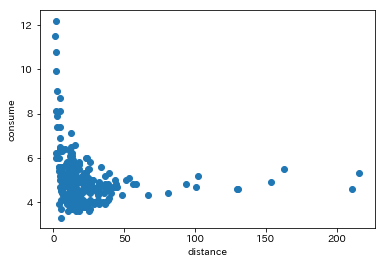

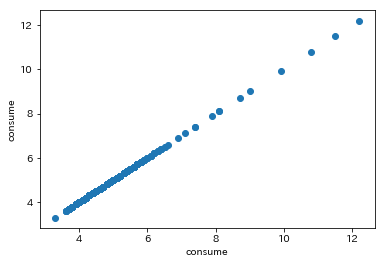

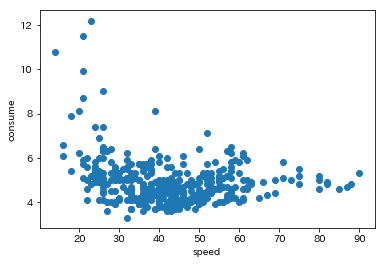

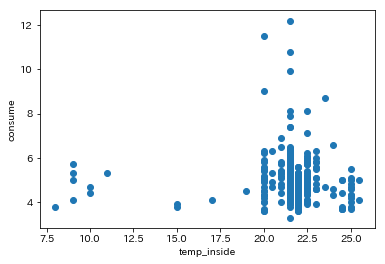

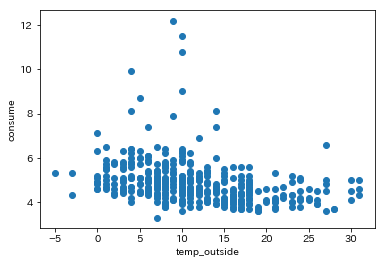

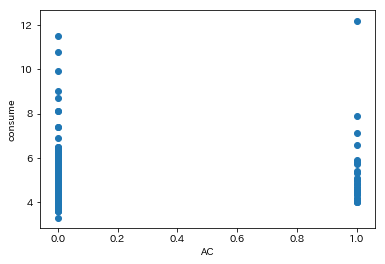

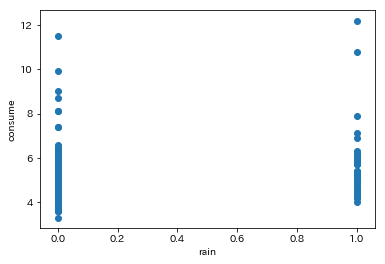

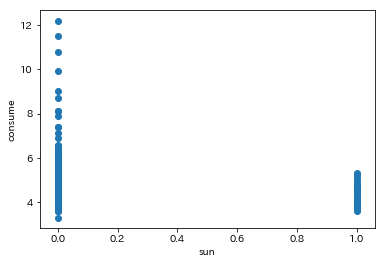

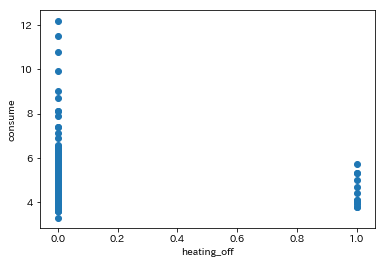

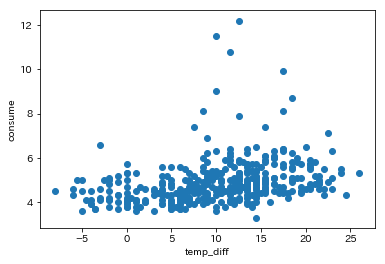

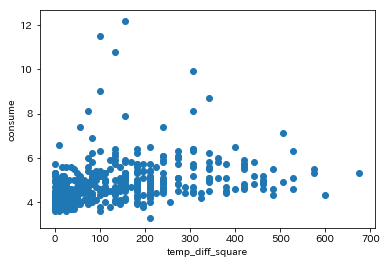

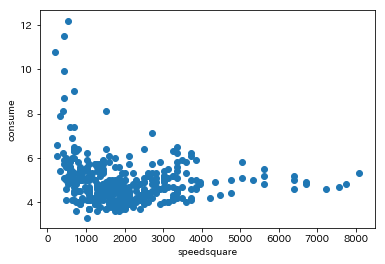

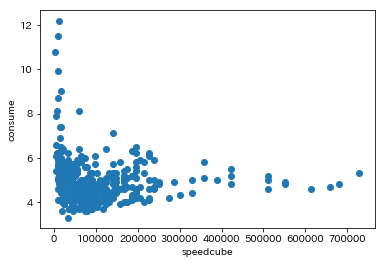

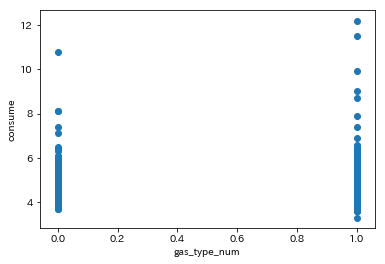

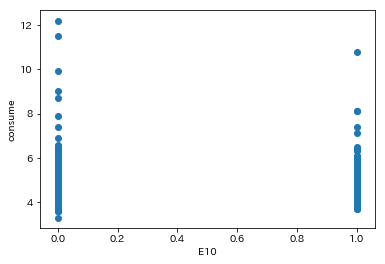

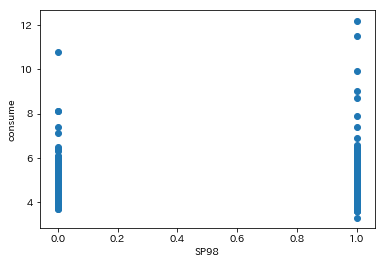

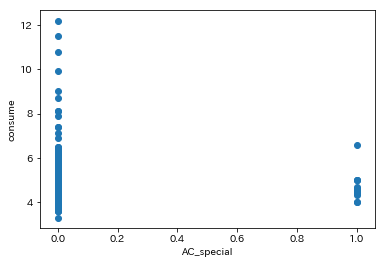

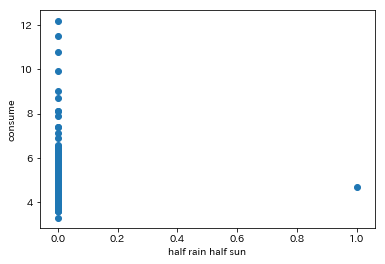

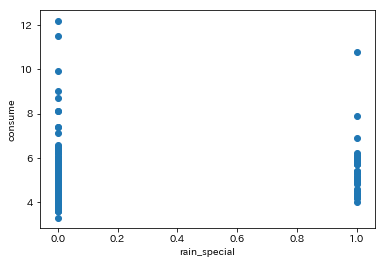

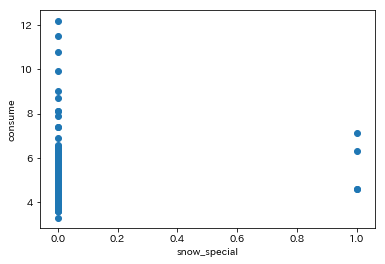

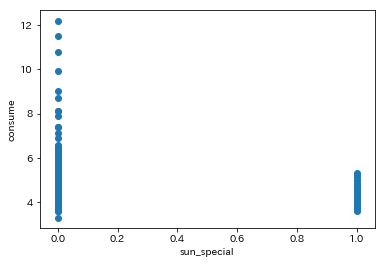

In [39]:
for column in df.columns:
    plt.scatter(df[column], df['consume'])
    plt.xlabel(column)
    plt.ylabel('consume')
    plt.show()

### 外れ値⇒Day3では非線形アルゴリズムも扱うため外れ値も考慮⇒Day４で再採用⇒してみるも精度でないので却下

- 外れ値の対処
- 先生のコメントで目的変数に使用するのはご法度
- 説明変数に適用したとしても除外するより置換したほうがベターである。

### 説明変数と目的変数の分割

In [40]:
y = df['consume']
df1 = df
df1.drop('consume',axis=1,inplace=True)

In [41]:
df1.shape

(388, 20)

- 外れ値の対処をしていく。説明変数は正規分布に従っていると仮定して、３σを超えるデータを外れ値とする。また、外れ値には中央値を置換する。

In [42]:
#３σの対象は１００個体ほど
def outlier_3s(df1):

    for i in range(len(df1.columns)):

        # 列を抽出する
        col = df1.iloc[:,i]

        # 平均と標準偏差
        average = np.mean(col)
        sd = np.std(col)

        # 外れ値の基準点
        outlier_min = average - (sd) * 3
        outlier_max = average + (sd) * 3

        # 範囲から外れている値を除く
        col[col < outlier_min] = None
        col[col > outlier_max] = None

    return df1

In [43]:
#5σの対象は４４個体
def outlier_5s(df1):

    for i in range(len(df1.columns)):

        # 列を抽出する
        col = df1.iloc[:,i]

        # 平均と標準偏差
        average = np.mean(col)
        sd = np.std(col)

        # 外れ値の基準点
        outlier_min = average - (sd) * 5
        outlier_max = average + (sd) * 5

        # 範囲から外れている値を除く
        col[col < outlier_min] = None
        col[col > outlier_max] = None

    return df1

In [44]:
#４分位範囲を外れ値として判定
def outlier_iqr(df1):

    for i in range(len(df.columns)):

        # 列を抽出する
        col = df.iloc[:,i]

        # 四分位数
        q1 = col.describe()['25%']
        q3 = col.describe()['75%']
        iqr = q3 - q1 #四分位範囲

        # 外れ値の基準点
        outlier_min = q1 - (iqr) * 1.5
        outlier_max = q3 + (iqr) * 1.5

        # 範囲から外れている値を除く
        col[col < outlier_min] = None
        col[col > outlier_max] = None

    return df1

In [45]:
#標準偏差OR４分位をNaNに
#df1 = outlier_3s(df1)
#df1 = outlier_5s(df1)
#df1 = outlier_iqr(df1)

#行ごと削除
#df1 = df.dropna(how='any', axis=0)

#置換
#df1 = df1.fillna(df.median())#中央値で置換⇒５σの中央値が一番よい。
#df1 = df1.fillna(df.mean())#平均値で置換
#df1 = df1.fillna(df.mode().iloc[0])#最頻値で置換。
#df1 = df1.fillna(method='ffill')#前の値で埋める
#df1 = df1.fillna(method='bfill')#後ろの値で埋める。⇒使えない

In [46]:
display(df1.shape)
display(df1.head(3))

(388, 20)

,distance,speed,temp_inside,temp_outside,AC,rain,sun,heating_off,temp_diff,temp_diff_square,speedsquare,speedcube,gas_type_num,E10,SP98,AC_special,half rain half sun,rain_special,snow_special,sun_special
0,28.0,26.0,21.5,12.0,0.0,0.0,0.0,0.0,9.5,90.25,676.0,17576.0,0.0,1,0,0,0,0,0,0
1,12.0,30.0,21.5,13.0,0.0,0.0,0.0,0.0,8.5,72.25,900.0,27000.0,0.0,1,0,0,0,0,0,0
2,11.2,38.0,21.5,15.0,0.0,0.0,0.0,0.0,6.5,42.25,1444.0,54872.0,0.0,1,0,0,0,0,0,0


In [47]:
X=df1
X.head(2)

,distance,speed,temp_inside,temp_outside,AC,rain,sun,heating_off,temp_diff,temp_diff_square,speedsquare,speedcube,gas_type_num,E10,SP98,AC_special,half rain half sun,rain_special,snow_special,sun_special
0,28.0,26.0,21.5,12.0,0.0,0.0,0.0,0.0,9.5,90.25,676.0,17576.0,0.0,1,0,0,0,0,0,0
1,12.0,30.0,21.5,13.0,0.0,0.0,0.0,0.0,8.5,72.25,900.0,27000.0,0.0,1,0,0,0,0,0,0


### データ分割

In [48]:
#交差検証及びグリッドサーチの呼び出し
from sklearn.model_selection import train_test_split, GridSearchCV

In [49]:
#Day3はテストデータは1割で、データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

### 重回帰分析での試行

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
cv = LinearRegression()
model = cv.fit(X_train, y_train)
print("Trainスコア:",model.score(X_train,y_train))
print("Testスコア:",model.score(X_test,y_test))
#過学習を大分起こしている

Trainスコア: 0.5032992986418785
Testスコア: 0.3868853367051214


In [55]:
y_pred = model.predict(X_test)

In [56]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)

In [57]:
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

テストデータに対して
 MSE=1.001
 RMSE=1.001
 MAE=0.557


### 説明変数の標準化

In [58]:
# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# テストデータも標準化:ここでポイント、訓練データの平均分散を基準にして、テストデータを標準化すること。fitが入ると平均分散がアップデートされてるので、訓練データはfit_transform、テストデータはtransformで計算
#X_test = scaler.fit_transform(X_test)
X_test = scaler.transform(X_test)

## 学習と評価

### 重回帰分析

In [59]:
cv = LinearRegression()
model = cv.fit(X_train, y_train)
print("Trainスコア:",model.score(X_train,y_train))
print("Testスコア:",model.score(X_test,y_test))
#過学習を大分起こしている

Trainスコア: 0.5032992986418785
Testスコア: 0.3868853367051225


In [60]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

テストデータに対して
 MSE=1.001
 RMSE=1.001
 MAE=0.557


### Lasso回帰

In [58]:
#params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01, 1e-3, 1e-5, 1e-8, 1e-10, 1e-15, 1e-20, 1e-25, 1e-30, 0.0]}
params = {"alpha":np.logspace(-3, 2, 50)}
cv2 = GridSearchCV(Lasso(), params, cv=5, scoring="r2", return_train_score=True)
model2=cv2.fit(X_train,y_train)

print("Trainスコア:",cv2.score(X_train,y_train))
print("Testスコア:",cv2.score(X_test,y_test))
print("最適なパラメーター =", cv2.best_params_, "精度 =", cv2.best_score_)

y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )


C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

Trainスコア: 0.2909742310786334
Testスコア: 0.21565229341764225
最適なパラメーター = {'alpha': 0.02682695795279726} 精度 = 0.13482400688997687
テストデータに対して
 MSE=1.281
 RMSE=1.132
 MAE=0.622


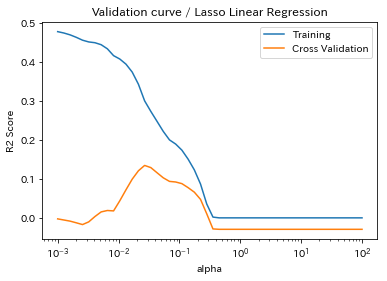

In [59]:
plt.semilogx(params["alpha"], cv2.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], cv2.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / Lasso Linear Regression")
plt.legend()
plt.show()

### Ridge回帰

In [60]:
# ハイパーパラメータのチューニング
params = {"alpha":np.logspace(-2, 4, 24)}
cv3 = GridSearchCV(Ridge(), params, cv=5, scoring="r2", return_train_score=True)
model3 = cv3.fit(X_train, y_train)

print("Trainスコア:",cv3.score(X_train,y_train))
print("Testスコア:",cv3.score(X_test,y_test))
print("最適なパラメーター =", cv3.best_params_, "精度 =", cv3.best_score_)

y_pred = model3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.31225425718935285
Testスコア: 0.19617759683958647
最適なパラメーター = {'alpha': 24.620924014946254} 精度 = 0.1523151266123957
テストデータに対して
 MSE=1.313
 RMSE=1.146
 MAE=0.633


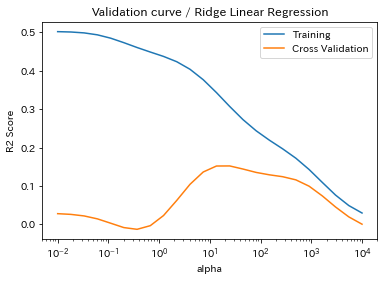

In [61]:
plt.semilogx(params["alpha"], cv3.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], cv3.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / Ridge Linear Regression")
plt.legend()
plt.show()

### Elastic回帰

In [62]:
ElasticNet

sklearn.linear_model.coordinate_descent.ElasticNet

In [63]:
# ハイパーパラメータのチューニング
params = {"alpha":np.logspace(-3, 2, 24)}
cv4 = GridSearchCV(ElasticNet(), params, cv=5, scoring="r2", return_train_score=True)
model4 = cv4.fit(X_train, y_train)

print("Trainスコア:",cv4.score(X_train,y_train))
print("Testスコア:",cv4.score(X_test,y_test))
print("最適なパラメーター =", cv4.best_params_, "精度 =", cv4.best_score_)

y_pred = model4.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

Trainスコア: 0.310826158458094
Testスコア: 0.2162445747983579
最適なパラメーター = {'alpha': 0.0332459793227094} 精度 = 0.13500572367061364
テストデータに対して
 MSE=1.28
 RMSE=1.131
 MAE=0.623


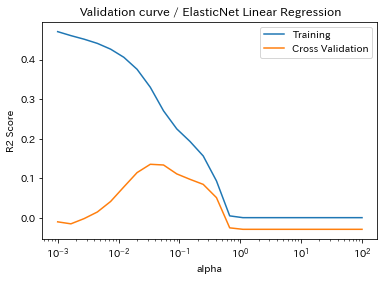

In [64]:
plt.semilogx(params["alpha"], cv4.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], cv4.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / ElasticNet Linear Regression")
plt.legend()
plt.show()

### 線形サポートベクターマシーン

In [65]:
params_cnt = 20
params = {"C":np.logspace(0,1,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
cv5 = GridSearchCV(SVR(kernel="linear"), params, cv=5, scoring="r2", return_train_score=True)
# cv5 = SVR(kernel="linear")
model5 = cv5.fit(X_train, y_train)

print("Trainスコア:",model5.score(X_train,y_train))
print("Testスコア:",model5.score(X_test,y_test))
print("最適なパラメーター =", model5.best_params_, "精度 =", model5.best_score_)

y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.41594264452813345
Testスコア: 0.24318456983501557
最適なパラメーター = {'C': 1.0, 'epsilon': 0.6951927961775606} 精度 = 0.07989374328771777
テストデータに対して
 MSE=1.236
 RMSE=1.112
 MAE=0.605


C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


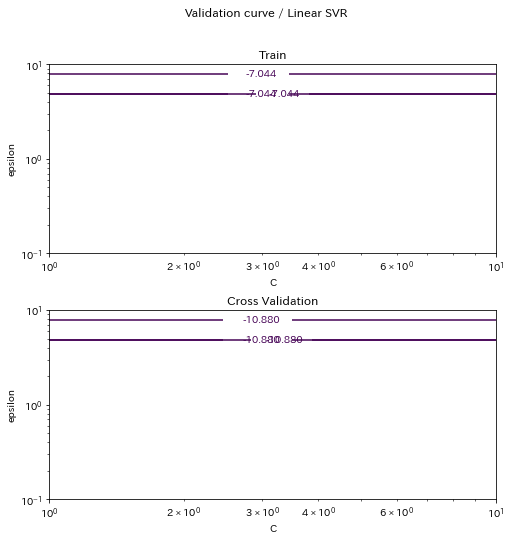

In [66]:
plt_x, plt_y = np.meshgrid(params["C"], params["epsilon"])
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace = 0.3)
for i in range(2):
    if i==0:
        plt_z = np.array(cv5.cv_results_["mean_train_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Train"
    else:
        plt_z = np.array(cv5.cv_results_["mean_test_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Cross Validation"
    ax = fig.add_subplot(2, 1, i+1)
    CS = ax.contour(plt_x, plt_y, plt_z, levels=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
    ax.clabel(CS, CS.levels, inline=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("C")
    ax.set_ylabel("epsilon")
    ax.set_title(title)
plt.suptitle("Validation curve / Linear SVR")
plt.show()

### 非線形サポートベクターマシーン

In [67]:
params_cnt = 20
params = {"C":np.logspace(0,1,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
cv6 = GridSearchCV(SVR(), params, cv=5, scoring="r2", return_train_score=True)
# cv6 = SVR()
model6 = cv6.fit(X_train, y_train)

print("Trainスコア:",model6.score(X_train,y_train))
print("Testスコア:",model6.score(X_test,y_test))
print("最適なパラメーター =", model6.best_params_, "精度 =", model6.best_score_)

y_pred = model6.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.4909637041156504
Testスコア: 0.3419130428923751
最適なパラメーター = {'C': 3.79269019073225, 'epsilon': 0.33598182862837817} 精度 = 0.28533440200221344
テストデータに対して
 MSE=1.075
 RMSE=1.037
 MAE=0.56


C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


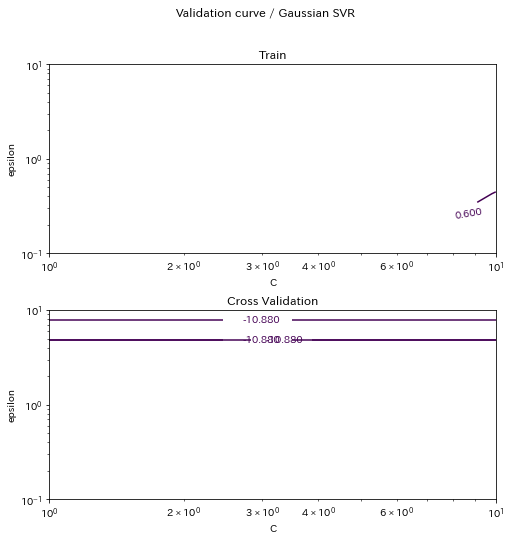

In [68]:
plt_x, plt_y = np.meshgrid(params["C"], params["epsilon"])
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace = 0.3)
for i in range(2):
    if i==0:
        plt_z = np.array(model6.cv_results_["mean_train_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Train"
    else:
        plt_z = np.array(model6.cv_results_["mean_test_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Cross Validation"
    ax = fig.add_subplot(2, 1, i+1)
    CS = ax.contour(plt_x, plt_y, plt_z, levels=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
    ax.clabel(CS, CS.levels, inline=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("C")
    ax.set_ylabel("epsilon")
    ax.set_title(title)
plt.suptitle("Validation curve / Gaussian SVR")
plt.show()

In [69]:
# # SVMの実行
# param_grid = {'kernel':['linear', 'rbf'],'C':[0.01,0.05,0.1,1,10,20,50]}
# cv7 = GridSearchCV(SVR(), param_grid=param_grid,cv=5)

# model7=cv7.fit(X_train,y_train) 
# print("Trainスコア:",model7.score(X_train,y_train))
# print("Testスコア:",model7.score(X_test,y_test))
# print("最適なパラメーター =", model7.best_params_, "精度 =", model7.best_score_)

# # 未知のデータを識別する
# print(cv7.predict(X_test))

# # 決定領域を描画する
# #plot_decision_regions(X_train, y_train, classifier=cv7)
# plt.plot(X_test[:,0],X_test[:,1], color="g", marker="o",ls="")
# plt.xlabel('X')
# plt.ylabel('y')
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

In [70]:
params = {'n_estimators': [2,3, 5,6,8, 10],
              'max_depth': [2,3,4, 5]}
cv8 = GridSearchCV(RandomForestRegressor(), params, cv=5, scoring="r2", return_train_score=True)
model8 = cv8.fit(X_train, y_train)

# clf8 = RandomForestRegressor()
# model8 = clf8.fit(X_train, y_train)

print("Trainスコア:",model8.score(X_train,y_train))
print("Testスコア:",model8.score(X_test,y_test))
print()
print("最適なパラメーター =", model8.best_params_, "精度 =", model8.best_score_)

y_pred = model8.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )


# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# print()
# print(model8.feature_importances_)
# pd.DataFrame(clf8.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
# plt.ylabel("Importance")
# plt.xlabel("Columns")
# plt.show()

Trainスコア: 0.7749067493516405
Testスコア: 0.6286213858377288

最適なパラメーター = {'max_depth': 5, 'n_estimators': 10} 精度 = 0.4872207588876472
テストデータに対して
 MSE=0.606
 RMSE=0.779
 MAE=0.518


### 単層ニューラルネットワーク

In [71]:
def reg_model():
    model = Sequential()
    model.add(Dense(10, input_dim=20, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(1))

    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

Train on 349 samples, validate on 39 samples
Epoch 1/300
349/349 [==============================] - 1s 1ms/step - loss: 19.7014 - acc: 0.0000e+00 - val_loss: 19.5954 - val_acc: 0.0000e+00
Epoch 2/300
349/349 [==============================] - 0s 143us/step - loss: 14.6491 - acc: 0.0000e+00 - val_loss: 14.0912 - val_acc: 0.0000e+00
Epoch 3/300
349/349 [==============================] - 0s 120us/step - loss: 9.2284 - acc: 0.0029 - val_loss: 8.1240 - val_acc: 0.0000e+00
Epoch 4/300
349/349 [==============================] - 0s 123us/step - loss: 4.6569 - acc: 0.0086 - val_loss: 3.7994 - val_acc: 0.0256
Epoch 5/300
349/349 [==============================] - 0s 135us/step - loss: 2.3465 - acc: 0.0258 - val_loss: 2.1017 - val_acc: 0.0256
Epoch 6/300
349/349 [==============================] - 0s 123us/step - loss: 1.6706 - acc: 0.0372 - val_loss: 1.6690 - val_acc: 0.0513
Epoch 7/300
349/349 [==============================] - 0s 138us/step - loss: 1.4080 - acc: 0.0573 - val_loss: 1.5235 - val_

Epoch 61/300
349/349 [==============================] - 0s 198us/step - loss: 0.4739 - acc: 0.0802 - val_loss: 0.8450 - val_acc: 0.1282
Epoch 62/300
349/349 [==============================] - 0s 238us/step - loss: 0.4680 - acc: 0.0831 - val_loss: 0.8511 - val_acc: 0.1282
Epoch 63/300
349/349 [==============================] - 0s 244us/step - loss: 0.4778 - acc: 0.0802 - val_loss: 0.8768 - val_acc: 0.1538
Epoch 64/300
349/349 [==============================] - 0s 126us/step - loss: 0.4613 - acc: 0.0802 - val_loss: 0.8131 - val_acc: 0.1538
Epoch 65/300
349/349 [==============================] - 0s 192us/step - loss: 0.4639 - acc: 0.0774 - val_loss: 0.8328 - val_acc: 0.1282  
Epoch 66/300
349/349 [==============================] - 0s 123us/step - loss: 0.4555 - acc: 0.0860 - val_loss: 0.8153 - val_acc: 0.1282
Epoch 67/300
349/349 [==============================] - 0s 132us/step - loss: 0.4557 - acc: 0.0831 - val_loss: 0.8099 - val_acc: 0.1282
Epoch 68/300
349/349 [========================

349/349 [==============================] - 0s 117us/step - loss: 0.3718 - acc: 0.0860 - val_loss: 0.7275 - val_acc: 0.1282
Epoch 122/300
349/349 [==============================] - 0s 132us/step - loss: 0.3833 - acc: 0.0831 - val_loss: 0.7354 - val_acc: 0.1282
Epoch 123/300
349/349 [==============================] - 0s 123us/step - loss: 0.3697 - acc: 0.0860 - val_loss: 0.7293 - val_acc: 0.1795
Epoch 124/300
349/349 [==============================] - 0s 126us/step - loss: 0.3685 - acc: 0.0888 - val_loss: 0.7627 - val_acc: 0.1538
Epoch 125/300
349/349 [==============================] - 0s 120us/step - loss: 0.3654 - acc: 0.0860 - val_loss: 0.7313 - val_acc: 0.1026
Epoch 126/300
349/349 [==============================] - 0s 138us/step - loss: 0.3700 - acc: 0.0802 - val_loss: 0.7148 - val_acc: 0.1282
Epoch 127/300
349/349 [==============================] - 0s 120us/step - loss: 0.3677 - acc: 0.0888 - val_loss: 0.7611 - val_acc: 0.1282
Epoch 128/300
349/349 [==============================] 

Epoch 240/300
349/349 [==============================] - 0s 115us/step - loss: 0.2997 - acc: 0.0802 - val_loss: 0.6660 - val_acc: 0.0769
Epoch 241/300
349/349 [==============================] - 0s 169us/step - loss: 0.3021 - acc: 0.0716 - val_loss: 0.6927 - val_acc: 0.0513
Epoch 242/300
349/349 [==============================] - 0s 126us/step - loss: 0.2984 - acc: 0.0802 - val_loss: 0.6656 - val_acc: 0.0513
Epoch 243/300
349/349 [==============================] - 0s 140us/step - loss: 0.2961 - acc: 0.0860 - val_loss: 0.6687 - val_acc: 0.0513
Epoch 244/300
349/349 [==============================] - 0s 132us/step - loss: 0.2939 - acc: 0.0860 - val_loss: 0.6761 - val_acc: 0.0513
Epoch 245/300
349/349 [==============================] - 0s 117us/step - loss: 0.2924 - acc: 0.0831 - val_loss: 0.6637 - val_acc: 0.0513
Epoch 246/300
349/349 [==============================] - 0s 126us/step - loss: 0.2952 - acc: 0.0860 - val_loss: 0.6495 - val_acc: 0.0513
Epoch 247/300
349/349 [==================

Epoch 300/300
39/39 [==============================] - 0s 718us/step
テストデータに対して
 MSE=0.686
 RMSE=0.828
 MAE=0.565


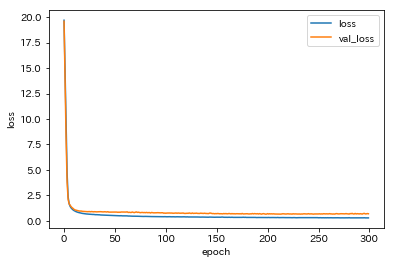

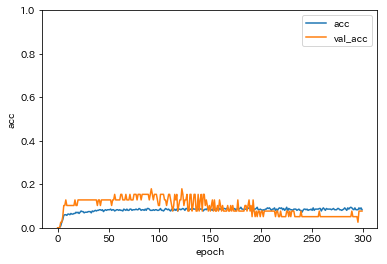

In [72]:
#300Epoch以上だと過学習で
estimator = KerasRegressor(build_fn=reg_model, epochs=300, batch_size=10,validation_data=(X_test, y_test), verbose=1)
model8 = estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

# show its root mean square error
# print("KERAS REG RMSE : %.2f" % (mse ** 0.5))
# print("Trainスコア:",estimator.score(X_train,y_train))
# print("Testスコア:",estimator.score(X_test,y_test))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

# 各epochにおける損失と精度をdfに入れる
df_val = pd.DataFrame(model8.history)

# グラフ化
df_val[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df_val[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [73]:
# seed = 7
# np.random.seed(seed)
# estimator = KerasRegressor(build_fn=reg_model, epochs=100, batch_size=5, verbose=0)
# kfold = KFold(n_splits=5, random_state=seed)

# # show its root mean square error
# results = cross_val_score(estimator, X, y, scoring='neg_mean_squared_error', cv=kfold)
# mse = -results.mean()
# print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

## 深層ニューラルネットワーク

In [74]:
def deep_reg_model():
    model = Sequential()
    model.add(Dense(10, input_dim=20, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # compile model
    adam = Adam(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])
    return model

Train on 349 samples, validate on 39 samples
Epoch 1/1000
349/349 [==============================] - 2s 6ms/step - loss: 12.7979 - acc: 0.0115 - val_loss: 3.1179 - val_acc: 0.1282
Epoch 2/1000
349/349 [==============================] - 0s 321us/step - loss: 2.4310 - acc: 0.0344 - val_loss: 2.2986 - val_acc: 0.0769
Epoch 3/1000
349/349 [==============================] - 0s 304us/step - loss: 2.0589 - acc: 0.0372 - val_loss: 1.4338 - val_acc: 0.1026
Epoch 4/1000
349/349 [==============================] - 0s 321us/step - loss: 1.6955 - acc: 0.0516 - val_loss: 1.6598 - val_acc: 0.1538
Epoch 5/1000
349/349 [==============================] - 0s 318us/step - loss: 1.5543 - acc: 0.0287 - val_loss: 1.3915 - val_acc: 0.1538
Epoch 6/1000
349/349 [==============================] - 0s 324us/step - loss: 1.1698 - acc: 0.0401 - val_loss: 1.1937 - val_acc: 0.1026
Epoch 7/1000
349/349 [==============================] - 0s 330us/step - loss: 1.1094 - acc: 0.0430 - val_loss: 1.5483 - val_acc: 0.1026
Epoc

349/349 [==============================] - 0s 381us/step - loss: 0.7141 - acc: 0.0659 - val_loss: 0.9159 - val_acc: 0.0769
Epoch 120/1000
349/349 [==============================] - 0s 350us/step - loss: 0.7184 - acc: 0.0573 - val_loss: 0.5560 - val_acc: 0.0513
Epoch 121/1000
349/349 [==============================] - 0s 338us/step - loss: 0.6764 - acc: 0.0745 - val_loss: 0.7383 - val_acc: 0.0769
Epoch 122/1000
349/349 [==============================] - 0s 318us/step - loss: 0.7120 - acc: 0.0716 - val_loss: 0.7635 - val_acc: 0.0513
Epoch 123/1000
349/349 [==============================] - 0s 361us/step - loss: 0.5764 - acc: 0.0774 - val_loss: 0.5839 - val_acc: 0.0769
Epoch 124/1000
349/349 [==============================] - 0s 355us/step - loss: 0.6999 - acc: 0.0630 - val_loss: 0.8072 - val_acc: 0.0769
Epoch 125/1000
349/349 [==============================] - 0s 367us/step - loss: 0.7169 - acc: 0.0573 - val_loss: 0.8508 - val_acc: 0.0769
Epoch 126/1000
349/349 [=========================

Epoch 237/1000
349/349 [==============================] - 0s 318us/step - loss: 0.5918 - acc: 0.0688 - val_loss: 0.9877 - val_acc: 0.1282
Epoch 238/1000
349/349 [==============================] - 0s 309us/step - loss: 0.5711 - acc: 0.0802 - val_loss: 0.8790 - val_acc: 0.0513
Epoch 239/1000
349/349 [==============================] - 0s 309us/step - loss: 0.6564 - acc: 0.0630 - val_loss: 1.3011 - val_acc: 0.1026
Epoch 240/1000
349/349 [==============================] - 0s 301us/step - loss: 0.5740 - acc: 0.0716 - val_loss: 1.0846 - val_acc: 0.0513
Epoch 241/1000
349/349 [==============================] - 0s 352us/step - loss: 0.6538 - acc: 0.0630 - val_loss: 1.2241 - val_acc: 0.0769
Epoch 242/1000
349/349 [==============================] - 0s 355us/step - loss: 0.6667 - acc: 0.0659 - val_loss: 1.0187 - val_acc: 0.0769
Epoch 243/1000
349/349 [==============================] - 0s 344us/step - loss: 0.6734 - acc: 0.0688 - val_loss: 0.8248 - val_acc: 0.0513
Epoch 244/1000
349/349 [==========

349/349 [==============================] - 0s 378us/step - loss: 0.6039 - acc: 0.0602 - val_loss: 0.9767 - val_acc: 0.0513
Epoch 297/1000
349/349 [==============================] - 0s 370us/step - loss: 0.6798 - acc: 0.0745 - val_loss: 0.9953 - val_acc: 0.0513
Epoch 298/1000
349/349 [==============================] - 0s 344us/step - loss: 0.6521 - acc: 0.0659 - val_loss: 1.0743 - val_acc: 0.0769
Epoch 299/1000
349/349 [==============================] - 0s 344us/step - loss: 0.6594 - acc: 0.0745 - val_loss: 1.0597 - val_acc: 0.0769
Epoch 300/1000
349/349 [==============================] - 0s 312us/step - loss: 0.6518 - acc: 0.0831 - val_loss: 0.8824 - val_acc: 0.0513
Epoch 301/1000
349/349 [==============================] - 0s 315us/step - loss: 0.6334 - acc: 0.0602 - val_loss: 0.8755 - val_acc: 0.1026
Epoch 302/1000
349/349 [==============================] - 0s 318us/step - loss: 0.6823 - acc: 0.0774 - val_loss: 0.6442 - val_acc: 0.1026
Epoch 303/1000
349/349 [=========================

349/349 [==============================] - 0s 341us/step - loss: 0.6203 - acc: 0.0716 - val_loss: 0.9747 - val_acc: 0.1026
Epoch 415/1000
349/349 [==============================] - 0s 347us/step - loss: 0.5789 - acc: 0.0688 - val_loss: 0.8702 - val_acc: 0.0769
Epoch 416/1000
349/349 [==============================] - 0s 309us/step - loss: 0.7088 - acc: 0.0688 - val_loss: 0.7250 - val_acc: 0.1026
Epoch 417/1000
349/349 [==============================] - 0s 344us/step - loss: 0.6605 - acc: 0.0831 - val_loss: 0.6261 - val_acc: 0.1282
Epoch 418/1000
349/349 [==============================] - 0s 384us/step - loss: 0.6374 - acc: 0.0659 - val_loss: 0.5904 - val_acc: 0.0769
Epoch 419/1000
349/349 [==============================] - 0s 321us/step - loss: 0.6133 - acc: 0.0802 - val_loss: 301.9811 - val_acc: 0.0769
Epoch 420/1000
349/349 [==============================] - 0s 318us/step - loss: 0.5737 - acc: 0.0831 - val_loss: 143.0776 - val_acc: 0.1026
Epoch 421/1000
349/349 [=====================

Epoch 532/1000
349/349 [==============================] - 0s 350us/step - loss: 0.5797 - acc: 0.0774 - val_loss: 0.7294 - val_acc: 0.0769
Epoch 533/1000
349/349 [==============================] - 0s 372us/step - loss: 0.5820 - acc: 0.0774 - val_loss: 0.6175 - val_acc: 0.0769
Epoch 534/1000
349/349 [==============================] - 0s 332us/step - loss: 0.5378 - acc: 0.0802 - val_loss: 0.6282 - val_acc: 0.0769
Epoch 535/1000
349/349 [==============================] - 0s 321us/step - loss: 0.6348 - acc: 0.0630 - val_loss: 0.7967 - val_acc: 0.0513
Epoch 536/1000
349/349 [==============================] - 0s 321us/step - loss: 0.6224 - acc: 0.0831 - val_loss: 0.6802 - val_acc: 0.0513
Epoch 537/1000
349/349 [==============================] - 0s 315us/step - loss: 0.6210 - acc: 0.0745 - val_loss: 0.7606 - val_acc: 0.0513
Epoch 538/1000
349/349 [==============================] - 0s 324us/step - loss: 0.6568 - acc: 0.0745 - val_loss: 0.7706 - val_acc: 0.0769
Epoch 539/1000
349/349 [==========

349/349 [==============================] - 0s 335us/step - loss: 0.6918 - acc: 0.0659 - val_loss: 1.2162 - val_acc: 0.1026
Epoch 651/1000
349/349 [==============================] - 0s 318us/step - loss: 0.6324 - acc: 0.0688 - val_loss: 1.1404 - val_acc: 0.1026
Epoch 652/1000
349/349 [==============================] - 0s 341us/step - loss: 0.6477 - acc: 0.0774 - val_loss: 1.0232 - val_acc: 0.0769
Epoch 653/1000
349/349 [==============================] - 0s 347us/step - loss: 0.6705 - acc: 0.0602 - val_loss: 0.8739 - val_acc: 0.1026
Epoch 654/1000
349/349 [==============================] - 0s 341us/step - loss: 0.5492 - acc: 0.0716 - val_loss: 0.9841 - val_acc: 0.1026
Epoch 655/1000
349/349 [==============================] - 0s 358us/step - loss: 0.5599 - acc: 0.0688 - val_loss: 0.6350 - val_acc: 0.1026
Epoch 656/1000
349/349 [==============================] - 0s 361us/step - loss: 0.6112 - acc: 0.0745 - val_loss: 0.9612 - val_acc: 0.1026
Epoch 657/1000
349/349 [=========================

Epoch 709/1000
349/349 [==============================] - 0s 309us/step - loss: 0.5650 - acc: 0.0745 - val_loss: 180130.9359 - val_acc: 0.0769
Epoch 710/1000
349/349 [==============================] - ETA: 0s - loss: 0.5728 - acc: 0.081 - 0s 352us/step - loss: 0.5731 - acc: 0.0860 - val_loss: 201165.8041 - val_acc: 0.0769
Epoch 711/1000
349/349 [==============================] - 0s 341us/step - loss: 0.5311 - acc: 0.0860 - val_loss: 317277.2960 - val_acc: 0.1026
Epoch 712/1000
349/349 [==============================] - 0s 315us/step - loss: 0.5536 - acc: 0.0917 - val_loss: 322419.6838 - val_acc: 0.0769
Epoch 713/1000
349/349 [==============================] - 0s 335us/step - loss: 0.5812 - acc: 0.0745 - val_loss: 374707.6167 - val_acc: 0.0769
Epoch 714/1000
349/349 [==============================] - ETA: 0s - loss: 0.5459 - acc: 0.066 - 0s 321us/step - loss: 0.5587 - acc: 0.0774 - val_loss: 552875.9227 - val_acc: 0.0769
Epoch 715/1000
349/349 [==============================] - 0s 347us

Epoch 767/1000
349/349 [==============================] - 0s 312us/step - loss: 0.5656 - acc: 0.0688 - val_loss: 90.0981 - val_acc: 0.0769
Epoch 768/1000
349/349 [==============================] - 0s 327us/step - loss: 0.5802 - acc: 0.0630 - val_loss: 1.2213 - val_acc: 0.0513
Epoch 769/1000
349/349 [==============================] - 0s 312us/step - loss: 0.6889 - acc: 0.0716 - val_loss: 1.1902 - val_acc: 0.0769
Epoch 770/1000
349/349 [==============================] - 0s 335us/step - loss: 0.5992 - acc: 0.0573 - val_loss: 1.1990 - val_acc: 0.1026
Epoch 771/1000
349/349 [==============================] - 0s 332us/step - loss: 0.5737 - acc: 0.0745 - val_loss: 1.1122 - val_acc: 0.1026
Epoch 772/1000
349/349 [==============================] - 0s 318us/step - loss: 0.6339 - acc: 0.0659 - val_loss: 1.0071 - val_acc: 0.0769
Epoch 773/1000
349/349 [==============================] - 0s 361us/step - loss: 0.5603 - acc: 0.0745 - val_loss: 1.0243 - val_acc: 0.0769
Epoch 774/1000
349/349 [=========

349/349 [==============================] - 0s 315us/step - loss: 0.4590 - acc: 0.0688 - val_loss: 9.9827 - val_acc: 0.0769
Epoch 827/1000
349/349 [==============================] - 0s 335us/step - loss: 0.5060 - acc: 0.0860 - val_loss: 1.3634 - val_acc: 0.0769
Epoch 828/1000
349/349 [==============================] - 0s 332us/step - loss: 0.5776 - acc: 0.0659 - val_loss: 1.0308 - val_acc: 0.0769
Epoch 829/1000
349/349 [==============================] - 0s 378us/step - loss: 0.5756 - acc: 0.0774 - val_loss: 1.1251 - val_acc: 0.1026
Epoch 830/1000
349/349 [==============================] - 0s 358us/step - loss: 0.5217 - acc: 0.0716 - val_loss: 2.6103 - val_acc: 0.0769
Epoch 831/1000
349/349 [==============================] - 0s 301us/step - loss: 0.5770 - acc: 0.0831 - val_loss: 4.7128 - val_acc: 0.1026
Epoch 832/1000
349/349 [==============================] - 0s 341us/step - loss: 0.6071 - acc: 0.0688 - val_loss: 21.2654 - val_acc: 0.0513
Epoch 833/1000
349/349 [========================

349/349 [==============================] - 0s 307us/step - loss: 0.5346 - acc: 0.0716 - val_loss: 0.6396 - val_acc: 0.0769
Epoch 945/1000
349/349 [==============================] - 0s 318us/step - loss: 0.6064 - acc: 0.0602 - val_loss: 0.8275 - val_acc: 0.0769
Epoch 946/1000
349/349 [==============================] - 0s 335us/step - loss: 0.5676 - acc: 0.0659 - val_loss: 0.8023 - val_acc: 0.1026
Epoch 947/1000
349/349 [==============================] - 0s 350us/step - loss: 0.6088 - acc: 0.0602 - val_loss: 1.5952 - val_acc: 0.0769
Epoch 948/1000
349/349 [==============================] - 0s 330us/step - loss: 0.5476 - acc: 0.0802 - val_loss: 0.4786 - val_acc: 0.0769
Epoch 949/1000
349/349 [==============================] - 0s 312us/step - loss: 0.5366 - acc: 0.0688 - val_loss: 0.5997 - val_acc: 0.1026
Epoch 950/1000
349/349 [==============================] - 0s 350us/step - loss: 0.4856 - acc: 0.0802 - val_loss: 0.6124 - val_acc: 0.1026
Epoch 951/1000
349/349 [=========================

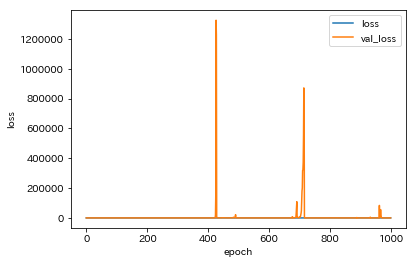

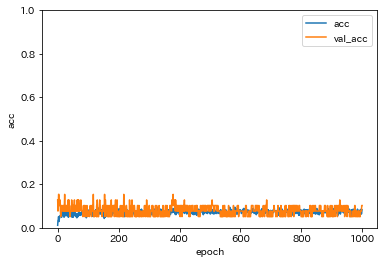

In [75]:
estimator = KerasRegressor(build_fn=deep_reg_model, epochs=1000, batch_size=10,validation_data=(X_test, y_test), verbose=1)
model9 = estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

# show its root mean square error
# print("KERAS REG RMSE : %.2f" % (mse ** 0.5))
# print("Trainスコア:",estimator.score(X_train,y_train))
# print("Testスコア:",estimator.score(X_test,y_test))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print()
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

# 各epochにおける損失と精度をdfに入れる
df_val = pd.DataFrame(model9.history)

# グラフ化
df_val[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df_val[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [76]:
# seed = 7
# np.random.seed(seed)
# estimator = KerasRegressor(build_fn=deep_reg_model, epochs=100, batch_size=5, verbose=0)
# kfold = KFold(n_splits=5, random_state=seed)

# # show its root mean square error
# results = cross_val_score(estimator, X, y, scoring='neg_mean_squared_error', cv=kfold)
# mse = -results.mean()
# print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

### XGBoost

In [61]:
import xgboost as xgb

In [62]:
# 動かすパラメータを明示的に表示
params = {"learning_rate":[0.01,0.1,0.3,0.5],
          "max_depth": [2,3,5,6,9,10],
          "subsample":[0.5,0.8,0.9,1],
          "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索:最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 
cv10 = GridSearchCV(mod, params, cv = 5, scoring="r2", return_train_score=True)
model10 = cv10.fit(X_train, y_train)
#model10 = mod.fit(X_train, y_train)

print("Trainスコア:",model10.score(X_train,y_train))
print("Testスコア:",model10.score(X_test,y_test))
print("最適なパラメーター =", model10.best_params_, "精度 =", model10.best_score_)

y_pred = model10.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MSE=%s"%round(mse,3) )
print(" RMSE=%s"%round(np.sqrt(mse), 3) )
print(" MAE=%s"%round(mae,3) )

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

Trainスコア: 0.9750348736892778
Testスコア: 0.6996600946873799
最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 0.5} 精度 = 0.55166361183475
テストデータに対して
 MSE=0.49
 RMSE=0.7
 MAE=0.476


/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


## チューニング

### ステップワイズ法

In [79]:
from sklearn.feature_selection import SelectFromModel#Day4追加
from sklearn.feature_selection import RFECV#Day4追加
from sklearn.linear_model import LassoCV#Day4追加

In [80]:
#あらかじめグリッドサーチで探索
# grid = {
#     'estimator__fit_intercept': [True, False],
#     'estimator__normalize': [True, False],
# }

# estimator = LinearRegression()

# selector = RFECV(estimator, step=1, cv=4)
# clf = GridSearchCV(selector, grid, cv=4)
# clf.fit(X_train, y_train)

# print(clf.best_estimator_)
# print(clf.best_estimator_.ranking_)

In [81]:
estimator = LinearRegression(copy_X=True, fit_intercept=True,n_jobs=1, normalize=True)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=4, scoring='neg_mean_absolute_error')

# fitで特徴選択を実行
rfecv.fit(X_train, y_train)

RFECV(cv=4,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
   n_jobs=1, scoring='neg_mean_absolute_error', step=1, verbose=0)

In [82]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 8 1 2 1 6 1 1 1 7 5 3 4 1 1 1 1]


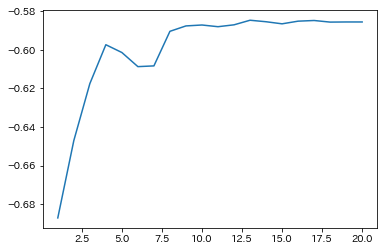

In [83]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [84]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([ True,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True])

In [85]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([False, False, False, False,  True, False,  True, False,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False])

In [86]:
# 削除してもよい特徴の名前を取得する
remove_feature = X.columns[remove_idx]
remove_feature

Index(['AC', 'sun', 'temp_diff', 'gas_type_num', 'E10', 'SP98', 'AC_special'], dtype='object')

In [87]:
# drop関数で特徴を削除
selected_X = X.drop(remove_feature, axis=1)
selected_X.head(3)

,distance,speed,temp_inside,temp_outside,rain,heating_off,temp_diff_square,speedsquare,speedcube,half rain half sun,rain_special,snow_special,sun_special
0,28.0,26.0,21.5,12.0,0.0,0.0,90.25,676.0,17576.0,0,0,0,0
1,12.0,30.0,21.5,13.0,0.0,0.0,72.25,900.0,27000.0,0,0,0,0
2,11.2,38.0,21.5,15.0,0.0,0.0,42.25,1444.0,54872.0,0,0,0,0


In [88]:
X2_train, X2_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.1, random_state=123)
# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
# テストデータも標準化:ここでポイント、訓練データの平均分散を基準にして、テストデータを標準化すること。fitが入ると平均分散がアップデートされてるので、訓練データはfit_transform、テストデータはtransformで計算
#X_test = scaler.fit_transform(X_test)
X2_test = scaler.transform(X2_test)

In [89]:
cv = LinearRegression()
model = cv.fit(X2_train, y_train)
print("Trainスコア:",model.score(X2_train,y_train))
print("Testスコア:",model.score(X2_test,y_test))

y_pred = model.predict(X2_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.501252709394542
Testスコア: 0.39048724415141556
テストデータに対して
 MAE=0.559


In [90]:
# 動かすパラメータを明示的に表示
params = {"learning_rate":[0.01,0.1,0.3,0.5],
          "max_depth": [2,3,5,6,9,10],
          "subsample":[0.5,0.8,0.9,1],
          "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索:最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 
cv10 = GridSearchCV(mod, params, cv = 5, scoring="r2", return_train_score=True)
model10 = cv10.fit(X2_train, y_train)
#model10 = mod.fit(X_train, y_train)

print("Trainスコア:",model10.score(X2_train,y_train))
print("Testスコア:",model10.score(X2_test,y_test))
print("最適なパラメーター =", model10.best_params_, "精度 =", model10.best_score_)

y_pred = model10.predict(X2_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.7984742566504655
Testスコア: 0.664957187161877
最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.8} 精度 = 0.5440824401583894
テストデータに対して
 MAE=0.49


In [91]:
params_cnt = 20
params = {"C":np.logspace(0,1,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
cv6 = GridSearchCV(SVR(), params, cv=5, scoring="r2", return_train_score=True)
# cv6 = SVR()
model6 = cv6.fit(X2_train, y_train)

print("Trainスコア:",model6.score(X2_train,y_train))
print("Testスコア:",model6.score(X2_test,y_test))
print("最適なパラメーター =", model6.best_params_, "精度 =", model6.best_score_)

y_pred = model6.predict(X2_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.5864925838927355
Testスコア: 0.4245754507928883
最適なパラメーター = {'C': 7.847599703514611, 'epsilon': 0.5455594781168519} 精度 = 0.3125422095821817
テストデータに対して
 MAE=0.559


### ランダムフォレストによる特徴量選択

Feature Importances:
	distance   : 0.524613
	speed      : 0.046381
	temp_inside : 0.049585
	temp_outside : 0.134215
	AC         : 0.023259
	rain       : 0.014308
	sun        : 0.004559
	heating_off : 0.000236
	temp_diff  : 0.028680
	temp_diff_square : 0.052611
	speedsquare : 0.046146
	speedcube  : 0.047193
	gas_type_num : 0.003570
	E10        : 0.003119
	SP98       : 0.002855
	AC_special : 0.002843
	half rain half sun : 0.000116
	rain_special : 0.011534
	snow_special : 0.002065
	sun_special : 0.002112



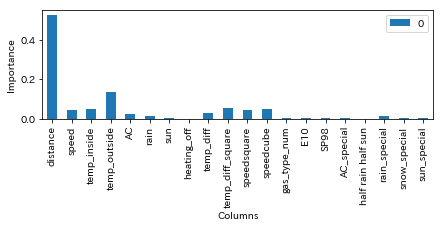

In [92]:
#ランダムフォレストを利用して特徴量の重要度を可視化する
clf8 = RandomForestRegressor()
model8 = clf8.fit(X_train, y_train)
#model8 = clf8.fit(X, y)


# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
fti = model8.feature_importances_
print('Feature Importances:')
for i, feat in enumerate(df1):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))

print()
pd.DataFrame(clf8.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Columns")
plt.show()

In [114]:
# 重要さ順に並んだindexを作成
important_index = [i for importance, i in sorted(zip(model8.feature_importances_, range(model8.n_features_)),key=lambda x:x[0], reverse=True)]
print(important_index)
print()
# 次元数=48, 32, 24, 16, 8, 4の6パターンで試す
for n_features in [20, 16, 8, 4]:
    index = important_index[:n_features]
    
    # 重要な特徴だけ選択した特徴量を新しく作る
    X3_train, X3_test = [x[:,index] for x in [X_train, X_test]]
 
    # 重要な特徴だけで学習
    clf11 = RandomForestRegressor(n_estimators=500, n_jobs=-1)
    model11 = clf11.fit(X3_train, y_train)
    
    # 重要な特徴だけ使った場合の性能を確認
    y_pred = model11.predict(X3_test)
    mae = mean_absolute_error(y_test, y_pred)
    print('テストデータに対して')
    print("{0}dimの場合".format(n_features))
    print(" MAE=%s"%round(mae,3) )

[0, 3, 9, 2, 11, 1, 10, 8, 4, 5, 17, 6, 12, 13, 14, 15, 19, 18, 7, 16]

テストデータに対して
20dimの場合
 MAE=0.496
テストデータに対して
16dimの場合
 MAE=0.497
テストデータに対して
8dimの場合
 MAE=0.512
テストデータに対して
4dimの場合
 MAE=0.517


In [94]:
# 動かすパラメータを明示的に表示
params = {"learning_rate":[0.01,0.1,0.3,0.5],
          "max_depth": [2,3,5,6,9,10],
          "subsample":[0.5,0.8,0.9,1],
          "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索:最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 
cv10 = GridSearchCV(mod, params, cv = 5, scoring="r2", return_train_score=True)
model10 = cv10.fit(X3_train, y_train)
#model10 = mod.fit(X3_train, y_train)

print("Trainスコア:",model10.score(X3_train,y_train))
print("Testスコア:",model10.score(X3_test,y_test))
print("最適なパラメーター =", model10.best_params_, "精度 =", model10.best_score_)

y_pred = model10.predict(X3_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.7473253061641203
Testスコア: 0.7617115840623077
最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 1} 精度 = 0.5290050069145845
テストデータに対して
 MAE=0.464


### 単変量統計p-valueによる枝刈り

各特徴量とターゲットの間で高い確信度で関連している特徴量を選択する手法。
特徴量を個別に考慮するので他の特徴量と組み合わさって意味を持つような特徴量は捨てられる。
高速で動作する。
p-値(特徴量とターゲットとの関連性の低さを示す指標)が高い特徴量を捨てる際の閾値をパラメータで指定する。

In [95]:
#統計データを調査:スタッドモデルを利用する
import statsmodels.api as sm

In [96]:
stad_X_train = sm.add_constant(X_train)
stad_X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, stad_X_train)
fitted = model.fit()

print('summary = \n', fitted.summary())

summary = 
                             OLS Regression Results                            
Dep. Variable:                consume   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     21.03
Date:                Fri, 16 Nov 2018   Prob (F-statistic):           2.47e-41
Time:                        19:41:36   Log-Likelihood:                -373.24
No. Observations:                 349   AIC:                             780.5
Df Residuals:                     332   BIC:                             846.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9060      0.039    126.

In [97]:
#P-value : 当てはめた統計モデル（母集団）に対してデータサンプルがきれいに収まっているかどうかの指標
pvalues = fitted.pvalues
feats = df1
print('P>|t| :')
for i, feat in enumerate(feats):
    print('\t{0:10s} : {1:>.6f}'.format(feat, pvalues[(i + 1)]))

P>|t| :
	distance   : 0.030908
	speed      : 0.000000
	temp_inside : 0.097624
	temp_outside : 0.284538
	AC         : 0.899384
	rain       : 0.000000
	sun        : 0.128196
	heating_off : 0.224970
	temp_diff  : 0.801090
	temp_diff_square : 0.072081
	speedsquare : 0.000000
	speedcube  : 0.000000
	gas_type_num : 0.362730
	E10        : 0.362730
	SP98       : 0.362730
	AC_special : 0.491219
	half rain half sun : 0.000000
	rain_special : 0.000000
	snow_special : 0.000000
	sun_special : 0.128196


#以下は粗相対的にp値が高い
- AC         : 0.899384
- sun        : 0.128196
- heating_off : 0.224970
- temp_diff  : 0.801090
- gas_type_num : 0.362730
- E10        : 0.362730
- SP98       : 0.362730
- AC_special : 0.491219
- sun_special : 0.128196

In [98]:
from sklearn.feature_selection import SelectPercentile

In [99]:
#上記結果より50%ほどで枝刈りしてみる
sp = SelectPercentile(percentile=50)

# 学習データに対して特徴量選択
sp.fit(X_train, y_train)

# 次元数削減
X4_train = sp.transform(X_train)
X4_test = sp.transform(X_test)

C:\Users\NATSUKI SANO\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [100]:
# 動かすパラメータを明示的に表示
params = {"learning_rate":[0.01,0.1,0.3,0.5],
          "max_depth": [2,3,5,6,9,10],
          "subsample":[0.5,0.8,0.9,1],
          "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索:最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 
cv10 = GridSearchCV(mod, params, cv = 5, scoring="r2", return_train_score=True)
model10 = cv10.fit(X4_train, y_train)
#model10 = mod.fit(X4_train, y_train)

print("Trainスコア:",model10.score(X4_train,y_train))
print("Testスコア:",model10.score(X4_test,y_test))
print("最適なパラメーター =", model10.best_params_, "精度 =", model10.best_score_)

y_pred = model10.predict(X4_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.5490023044079846
Testスコア: 0.4265221760865624
最適なパラメーター = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 1} 精度 = 0.13563710099486323
テストデータに対して
 MAE=0.592


In [101]:
cv = LinearRegression()
model = cv.fit(X4_train, y_train)
print("Trainスコア:",model.score(X4_train,y_train))
print("Testスコア:",model.score(X4_test,y_test))

y_pred = model.predict(X4_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.2564337398586207
Testスコア: 0.10633071645009096
テストデータに対して
 MAE=0.682


### XGBsoostとSelectFromModel埋め込み法

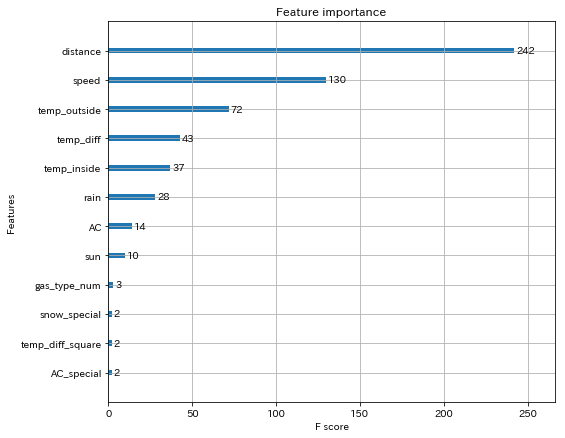

In [102]:
mod = xgb.XGBRegressor()
model10 = mod.fit(X, y)
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(8,7))
plot_importance(model10, ax=ax, max_num_features=20)
plt.show()

In [103]:
sfm = SelectFromModel(xgb.XGBRegressor(), threshold = "median")

In [104]:
sfm.fit(X, y)
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False,  True, False, False,
        True, False])

In [105]:
# 削除すべき特徴の名前を取得 
removed_idx2  = ~sfm.get_support()
print(removed_idx2)
print()
remove_feature2 = X.columns[removed_idx2]
print(remove_feature2)

[False False False False False False False  True False False  True  True
 False  True  True False  True  True False  True]

Index(['heating_off', 'speedsquare', 'speedcube', 'E10', 'SP98',
       'half rain half sun', 'rain_special', 'sun_special'],
      dtype='object')


In [106]:
# drop関数で特徴を削除
selected_X2 = X.drop(remove_feature2, axis=1)
selected_X2.head(3)

,distance,speed,temp_inside,temp_outside,AC,rain,sun,temp_diff,temp_diff_square,gas_type_num,AC_special,snow_special
0,28.0,26.0,21.5,12.0,0.0,0.0,0.0,9.5,90.25,0.0,0,0
1,12.0,30.0,21.5,13.0,0.0,0.0,0.0,8.5,72.25,0.0,0,0
2,11.2,38.0,21.5,15.0,0.0,0.0,0.0,6.5,42.25,0.0,0,0


In [108]:
X5_train, X5_test, y_train, y_test = train_test_split(selected_X2, y, test_size=0.1, random_state=123)

In [109]:
# 動かすパラメータを明示的に表示
params = {"learning_rate":[0.01,0.1,0.3,0.5],
          "max_depth": [2,3,5,6,9,10],
          "subsample":[0.5,0.8,0.9,1],
          "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索:最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 
cv10 = GridSearchCV(mod, params, cv = 5, scoring="r2", return_train_score=True)
model10 = cv10.fit(X5_train, y_train)
#model10 = mod.fit(X3_train, y_train)

print("Trainスコア:",model10.score(X5_train,y_train))
print("Testスコア:",model10.score(X5_test,y_test))
print("最適なパラメーター =", model10.best_params_, "精度 =", model10.best_score_)

y_pred = model10.predict(X5_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.9324896503456387
Testスコア: 0.706350924426592
最適なパラメーター = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5} 精度 = 0.5692599181602905
テストデータに対して
 MAE=0.466


In [110]:
cv = LinearRegression()
model = cv.fit(X5_train, y_train)
print("Trainスコア:",model.score(X5_train,y_train))
print("Testスコア:",model.score(X5_test,y_test))

y_pred = model.predict(X5_test)
mae = mean_absolute_error(y_test, y_pred)
print('テストデータに対して')
print(" MAE=%s"%round(mae,3) )

Trainスコア: 0.22121137751423292
Testスコア: 0.09975215128867398
テストデータに対して
 MAE=0.695


# 終わり